In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# fix random seed for reproducibility
numpy.random.seed(7)

In [2]:
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [3]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [4]:
# convert an array of values into a dataset matrix
#Time Series with LSTM
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0511 - 2s/epoch - 24ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0258 - 148ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0185 - 150ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0167 - 182ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0157 - 153ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0147 - 254ms/epoch - 3ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0136 - 243ms/epoch - 3ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0126 - 257ms/epoch - 3ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0116 - 488ms/epoch - 5ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0105 - 286ms/epoch - 3ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0097 - 302ms/epoch - 3ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0086 - 304ms/epoch - 3ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0077 - 270ms/epoch - 3ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0070 - 376ms/epoch - 4ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0060 - 265ms/epoch - 3ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0053 - 231ms/epoc

2/2 [==============================] - 0s 11ms/step


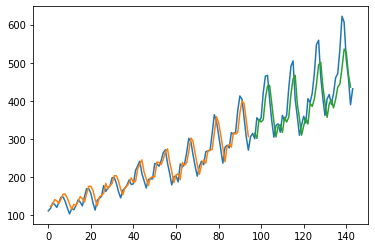

In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()